In [25]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import geopandas as gpd
import os

%matplotlib inline
DATA_DIR = '/Users/lee/Documents/UCLA/Year3/CS_130/project/uber-pickups-in-new-york-city'
DATA_FILES = ['uber-raw-data-apr14.csv','uber-raw-data-aug14.csv','uber-raw-data-jul14.csv','uber-raw-data-jun14.csv','uber-raw-data-may14.csv','uber-raw-data-sep14.csv']

uber_data_list = []
for data_file in DATA_FILES:
    df = pd.read_csv(os.path.join(DATA_DIR, data_file))
    uber_data_list.append(df)

uber_data = pd.concat(uber_data_list)
uber_data.head()
#829275 entries
#4534327 entries total

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [27]:
uber_data['Date/Time'] = pd.to_datetime(uber_data['Date/Time'], format="%m/%d/%Y %H:%M:%S")
uber_data['Month'] = uber_data['Date/Time'].dt.month
uber_data['Year'] = uber_data['Date/Time'].dt.year
uber_data['DayOfWeekNum'] = uber_data['Date/Time'].dt.dayofweek
uber_data['DayOfWeek'] = uber_data['Date/Time'].dt.weekday_name
uber_data['MonthDayNum'] = uber_data['Date/Time'].dt.day
uber_data['HourOfDay'] = uber_data['Date/Time'].dt.hour
uber_data['ChunkIndex'] = 4*uber_data['HourOfDay'] + uber_data['Date/Time'].dt.minute // 15 # which 15-minute block within the day is it in

uber_data.head()

,Date/Time,Lat,Lon,Base,Month,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay,ChunkIndex,Year
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,Tuesday,1,0,0,2014
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,Tuesday,1,0,1,2014
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,Tuesday,1,0,1,2014
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,Tuesday,1,0,1,2014
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,Tuesday,1,0,2,2014


In [28]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4534327 entries, 0 to 1028135
Data columns (total 11 columns):
Date/Time       datetime64[ns]
Lat             float64
Lon             float64
Base            object
Month           int64
DayOfWeekNum    int64
DayOfWeek       object
MonthDayNum     int64
HourOfDay       int64
ChunkIndex      int64
Year            int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 415.1+ MB


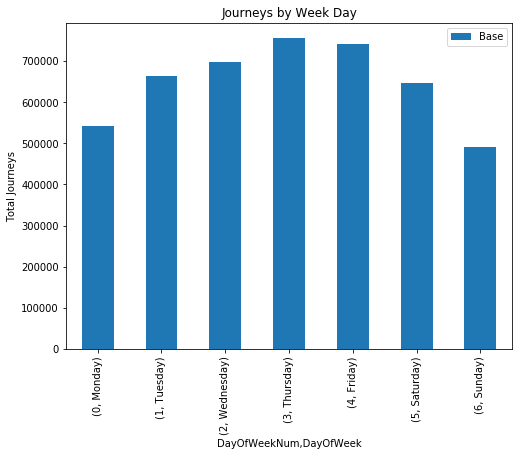

In [29]:
uber_weekdays = uber_data.pivot_table(index=['DayOfWeekNum', 'DayOfWeek'],
                                  values='Base',
                                  aggfunc='count')
uber_weekdays.plot(kind='bar', figsize=(8,6))
plt.ylabel('Total Journeys')
plt.title('Journeys by Week Day');

In [14]:
# Not displaying anything for now

# gdf = gpd.GeoDataFrame(
#     uber_data, geometry=gpd.points_from_xy(uber_data.Lon, uber_data.Lat))
# # gdf.head()

# gdf.crs = {'init': 'epsg:4326'}
# print(gdf.head())

# gdf = gdf.to_crs({'init': 'epsg:3395'})
# print(gdf.head())



In [30]:
from haversine import haversine

# x is lat space, y is lon space
min_lat, min_lon = min(uber_data['Lat']), min(uber_data['Lon'])
max_lat, max_lon = max(uber_data['Lat']), max(uber_data['Lon'])

max_x_dist = haversine((min_lat, min_lon), (max_lat, min_lon))
max_y_dist = haversine((min_lat, min_lon), (min_lat, max_lon))

x_nums, y_nums = 1000, 1000 # of cells in each axis
x_cell_size = max_x_dist / x_nums # in km
y_cell_size = max_y_dist / y_nums # in km

def cluster_coordinate(lat, lon):
    x_dist = haversine((min_lat, min_lon), (lat, min_lon))# dist along lat
    y_dist = haversine((min_lat, min_lon), (min_lat, lon))# dist along lon
    
    return x_dist // x_cell_size, y_dist // y_cell_size


print(min_lat, max_lat)
print(min_lon, max_lon)
# print()
# cluster_coordinate(40.7366, -73.9906)

# uber_data.head()
# 

39.6569 42.1166
-74.929 -72.0666


In [31]:
# add cluster coordinates to all entries in uber data
uber_data['ClusterCoordinateX'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[0]), axis=1)
uber_data['ClusterCoordinateY'] = uber_data.apply(lambda row: int(cluster_coordinate(row['Lat'], row['Lon'])[1]), axis=1)


In [17]:
# TESTS

# uber_data[uber_data['ClusterCoordinateX'] == 594][uber_data['ClusterCoordinateY']==406]

In [48]:

# count rides per 15-minute chunk for each (chunkindex, monthdaynum, dayofweeknum, coordX, coordY) as key
uber_rides_count = uber_data.pivot_table(index=[ 'ClusterCoordinateX', 'ClusterCoordinateY', 'Year', 'Month', 'DayOfWeekNum', 'MonthDayNum', 'ChunkIndex'],
                                  values='Base',
                                  aggfunc='count')
uber_rides_count.head()


,,,,,,,Base
ClusterCoordinateX,ClusterCoordinateY,Year,Month,DayOfWeekNum,MonthDayNum,ChunkIndex,
0,245,2014,8,4,1,78,1
4,268,2014,8,5,23,54,1
26,239,2014,7,5,12,57,1
75,271,2014,7,5,19,89,1
101,296,2014,7,5,12,91,1


In [49]:
# average count# across month, year
uber_rides_count = uber_rides_count.pivot_table(index=[ 'ClusterCoordinateX', 'ClusterCoordinateY', 'DayOfWeekNum', 'MonthDayNum', 'ChunkIndex'],
                                  values='Base',
                                  aggfunc='mean')

uber_rides_count.head()

,,,,,Base
ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,MonthDayNum,ChunkIndex,
0,245,4,1,78,1.0
4,268,5,23,54,1.0
26,239,5,12,57,1.0
75,271,5,19,89,1.0
101,296,5,12,91,1.0


In [65]:
# round Base column to nearest integer
uber_rides_count.Base = uber_rides_count.Base.round(0).astype(int)
uber_rides_count.head()

,,,,,Base
ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,MonthDayNum,ChunkIndex,
0,245,4,1,78,1
4,268,5,23,54,1
26,239,5,12,57,1
75,271,5,19,89,1
101,296,5,12,91,1


In [66]:
# START TRAINING STUFF HERE

# write uber data to output file
TRAIN_FILE = 'full_training.csv'
uber_rides_count.to_csv(TRAIN_FILE)

In [67]:
# NOW START TRAINING ---------------
dataset = pd.read_csv(TRAIN_FILE)
dataset.head()

,ClusterCoordinateX,ClusterCoordinateY,DayOfWeekNum,MonthDayNum,ChunkIndex,Base
0,0,245,4,1,78,1
1,4,268,5,23,54,1
2,26,239,5,12,57,1
3,75,271,5,19,89,1
4,101,296,5,12,91,1


In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007121 entries, 0 to 3007120
Data columns (total 6 columns):
ClusterCoordinateX    int64
ClusterCoordinateY    int64
DayOfWeekNum          int64
MonthDayNum           int64
ChunkIndex            int64
Base                  int64
dtypes: int64(6)
memory usage: 137.7 MB


In [69]:
dataset.loc[dataset['Base'].idxmax()]
# this ends up being JFK airport which seems accurate

ClusterCoordinateX    447
ClusterCoordinateY    324
DayOfWeekNum            0
MonthDayNum            12
ChunkIndex             87
Base                   63
Name: 2045528, dtype: int64

In [70]:
# stats for 15-minute increments
print('Min rides: {}, max rides: {}'.format(min(dataset['Base']), max(dataset['Base'])))
print('Average rides: {}'.format(dataset['Base'].mean()))
print('stddev rides: {}'.format(dataset['Base'].std()))

Min rides: 1, max rides: 63
Average rides: 1.423512721968953
stddev rides: 0.9634615510032023


In [71]:
# example_test = dataset[dataset['ClusterCoordinateX']==594][dataset['ClusterCoordinateY']==406][dataset['DayOfWeekNum']==0][dataset['MonthDayNum']==4].sort_values(by=['ChunkIndex'])
# example_test.plot(x='ChunkIndex', y='Base')



In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
print(pca.fit_transform(dataset))
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[[ -31.20666705 -216.70477926  391.60729383   15.60439988]
 [  -6.53404003 -194.22422867  394.99242185   -6.29848567]
 [  -9.96069823 -215.15768655  365.19786063    4.53051259]
 ...
 [  11.52803908  451.11041645 -181.84997257   -8.34038763]
 [  28.83569841  495.88361633 -178.92668781   -8.17719793]
 [  48.00212394  803.43365013 -332.97000916   -2.78176345]]
[0.41386489 0.31492885 0.21469932 0.05331811]
0.9968111682896806


In [77]:
# TRAINING STARTS

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# split dataset into (train, test)
# For now, splitting on all data tuples, not separating based on cluster
def split(dataset, train_fraction):
    msk = np.random.rand(len(dataset)) < train_fraction
    return dataset[msk], dataset[~msk]

train, test = split(dataset, .7)
features = dataset.columns[:5] # coordX, coordY, dayofweeknum, monthdaynum, chunkindex



In [100]:
# models
randf = RandomForestClassifier(n_estimators=30)
randf.fit(train[features], train['Base'])
print(randf.feature_importances_)

[0.16359256 0.13639697 0.06326894 0.33055457 0.30618695]


In [79]:
# models
# log_reg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=500)
# log_reg.fit(train[features], train['Base'])

In [101]:
# expected
expect = test['Base']

# predictions
randf_pred = randf.predict(test[features])
# log_reg_pred = log_reg.predict(test[features])


# print(list(zip(train[features], clf.feature_importances_)))

In [ ]:
confusion = pd.crosstab(expect, randf_pred, rownames=['Actual'], colnames=['Predicted'])
confusion

In [102]:
# metrics

from sklearn.metrics import mean_squared_error, accuracy_score

expected = np.array(expect)

print("RANDF mean_squared_error: {}".format(mean_squared_error(expected, randf_pred)))
print("RANDF accuracy: {}".format(accuracy_score(expected, randf_pred)))
print()

# print("LOGREG mean_squared_error: {}".format(mean_squared_error(expected, log_reg_pred)))
# print("LOGREG accuracy: {}".format(accuracy_score(expected, log_reg_pred)))
# print()

RANDF mean_squared_error: 0.9297400505841529
RANDF accuracy: 0.7121673151104937



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


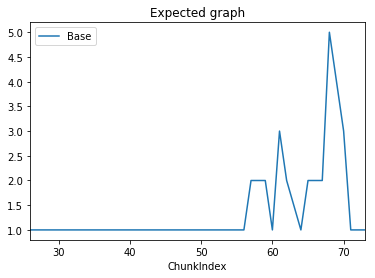

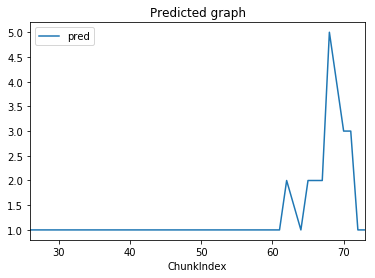

In [109]:
# example of running the model
# coordX, coordY, dayofweeknum, monthdaynum, chunkindex

# plot predicted nums, and true nums for each chunkindex

# ClusterCoordinateX	ClusterCoordinateY	DayOfWeekNum	MonthDayNum	ChunkIndex	Base
def visualize(clf, coordx, coordy, dayofweeknum, monthdaynum):
    
    expect = dataset[dataset['ClusterCoordinateX']==coordx][dataset['ClusterCoordinateY']==coordy][dataset['DayOfWeekNum']==dayofweeknum][dataset['MonthDayNum']==monthdaynum].sort_values(by=['ChunkIndex'])
    if expect.empty:
        return
    test_data = np.zeros((len(expect), 5))
    
    test_data[:, 0] = len(expect)*[coordx]
    test_data[:, 1] = len(expect)*[coordy]
    test_data[:, 2] = len(expect)*[dayofweeknum]
    test_data[:, 3] = len(expect)*[monthdaynum]
    test_data[:, 4] = expect['ChunkIndex']
    pred = clf.predict(test_data)
    expect['pred'] = pred
    
    expect.plot(x='ChunkIndex', y='Base', title='Expected graph')
    expect.plot(x='ChunkIndex', y='pred', title='Predicted graph')
    

visualize(randf, 447, 324, 0, 5)
#visualize(662, 317, 0, 18)
# visualize(653, 315, 3, 21)
#visualize(672, 369, 6, 17)

In [103]:
db = pd.read_csv('db_all_aug14box.csv')

def get_latlons_for_cluster(db, clusterX, clusterY):
    points = db[db['ClusterCoordinateX']==clusterX][db['ClusterCoordinateY']==clusterY][['Lat', 'Lon']]
    print(len(points))
    points['name'] = '[{} {}]'.format(clusterX, clusterY)
    points['color'] = '#FFFF00'
    points.to_csv('points.csv'.format(clusterX, clusterY), index=False)
    points.head()


get_latlons_for_cluster(db, 594, 406)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


38625
